# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from itertools import product
from sklearn.feature_selection import mutual_info_classif, RFE
import warnings
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
expression = pd.read_csv('/content/drive/MyDrive/expression_liu.tsv', sep='\t')

Mounted at /content/drive


# **Helper Functions**


In [2]:
def diffMeansEvalScore(featuresDF,labels):
  featuresDF['ICB Response']=labels

  class0 = featuresDF[featuresDF['ICB Response'] == 0.0]
  class1 = featuresDF[featuresDF['ICB Response'] == 1.0]

  class0=class0.drop(columns=["ICB Response"])
  class1=class1.drop(columns=["ICB Response"])

  featuresDF=featuresDF.drop(columns=['ICB Response'])

  sum=0
  for gene in featuresDF.columns:
    mean0=class0.loc[:,gene].mean()
    mean1=class1.loc[:,gene].mean()

    diff=np.abs(mean0-mean1)
    sum += diff
  return sum

In [3]:
'''

def LogRegTrainEvalScore(featuresDF,labels):
  featuresDF['ICB Response']=labels
  train_df, test_df = train_test_split(featuresDF, train_size=0.8, test_size=0.2, random_state=0, stratify=featuresDF.loc[:,'ICB Response'])
  train_labels = train_df.loc[:,'ICB Response']
  test_labels = test_df.loc[:,'ICB Response']
  train_df = train_df.drop(labels='ICB Response', axis=1)
  test_df = test_df.drop(labels='ICB Response', axis=1)

  param_grid = {
      'C': [0.001,0.01,0.1,1,10,100],
      'class_weight': [None,'balanced'],
      'solver': ['newton-cg','liblinear']}

  clf = LogisticRegression(random_state=0)
  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(train_df, train_labels)

  best_params_grid = grid_search.best_params_
  best_model_grid = grid_search.best_estimator_

  model_predictions = best_model_grid.predict(test_df)

  acc_score=accuracy_score(test_labels,model_predictions)

  return acc_score

  '''

"\n\ndef LogRegTrainEvalScore(featuresDF,labels):\n  featuresDF['ICB Response']=labels\n  train_df, test_df = train_test_split(featuresDF, train_size=0.8, test_size=0.2, random_state=0, stratify=featuresDF.loc[:,'ICB Response'])\n  train_labels = train_df.loc[:,'ICB Response']\n  test_labels = test_df.loc[:,'ICB Response']\n  train_df = train_df.drop(labels='ICB Response', axis=1)\n  test_df = test_df.drop(labels='ICB Response', axis=1)\n\n  param_grid = {\n      'C': [0.001,0.01,0.1,1,10,100],\n      'class_weight': [None,'balanced'],\n      'solver': ['newton-cg','liblinear']}\n\n  clf = LogisticRegression(random_state=0)\n  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')\n  grid_search.fit(train_df, train_labels)\n\n  best_params_grid = grid_search.best_params_\n  best_model_grid = grid_search.best_estimator_\n\n  model_predictions = best_model_grid.predict(test_df)\n\n  acc_score=accuracy_score(test_labels,model_predictions)\n\n  return acc_score\n\n  "

In [4]:
def logistic_regression_classifier(X, y):
  clf = LogisticRegression(random_state=0)
  param_grid = {
    'C': [0.001,0.01,0.1,1,10,100],
    'solver': ['newton-cg', 'liblinear'],
    'class_weight': [None, 'balanced'],
  }

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0, stratify=y)

  grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

  grid_search.fit(X_train, y_train)
  best_clf = grid_search.best_estimator_

  y_pred = best_clf.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred)

  return test_accuracy

In [5]:
def evaluate_rfe(X, y, n_features_to_select=60, step=1):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    logreg = LogisticRegression(random_state=0, class_weight='balanced', n_jobs=-1)
    rfe = RFE(estimator=logreg, n_features_to_select=n_features_to_select, step=step)

    rfe.fit(X_train, y_train)

    selected_features = pd.DataFrame({'Feature': X.columns,
                                      'Selected': rfe.support_,})
    s = selected_features[selected_features['Selected'] == True]

    selected_genes = s['Feature']

    filtered_exp = X[selected_genes]

    results_df = logistic_regression_classifier(filtered_exp, y)

    return results_df

In [18]:
def evaluate_MI(X, y, top_k=60):

  info_gain = mutual_info_classif(X, y, discrete_features='auto', random_state = 42)

  info_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
  info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False).reset_index(drop=True)

  if top_k is not None:
      info_gain_df = info_gain_df.head(top_k)
      info_gain_df = info_gain_df[info_gain_df['Information Gain'] > 0]

  selected_genes = info_gain_df['Feature'].tolist()

  filtered_exp = X[selected_genes]

  results_df = logistic_regression_classifier(filtered_exp, y)

  return results_df

# **Genetic Algorithms Implementation**

In [7]:
"""Initialize the population with chromosomes satisfying the max_selected_features constraint"""

def initialize_population(population_size, num_features, max_selected_features):
    population = np.zeros((population_size, num_features), dtype=int) # initialize the population with an array of num_features zeroes
    for i in range(population_size): # For every individual in the population...
        selected_indices = np.random.choice(num_features, size=max_selected_features, replace=False) # selecting max_selected_features random positions (indices)
        population[i, selected_indices] = 1 # adding 1 to those positions --> meaning these positions are selected
    return population

In [8]:
x = initialize_population(5, 10, 5)
x

array([[0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 1, 0, 1, 0, 0, 1, 0, 0, 1]])

In [9]:
"""Select the best num_parents individuals based on their fitness evaluation --> according to the rank-selection method. """

def select_parents(population, fitness_scores, num_parents):
    # Rank individuals by their fitness scores: the higher the fitness, the better the rank.
    # np.argsort returns indices that would sort an array, with the lowest value at the first index --> ascending order sorting
    # By using [::-1], we reverse the order to get indices of highest to lowest fitness scores --> descending order
    ranked_indices = np.argsort(fitness_scores)[::-1]

    # for example, if the fitness_scores is [1, 3, 5, 7, 2]
    # then sorting[::-1] would produce [7, 5, 3, 2, 1], with indices [3, 2, 1, 4, 0]

    # Calculate selection probabilities proportional to the rank (not the fitness score directly)
    # Total ranks will be the sum of numbers from 1 to len(population)
    # if the population is made of 5 individuals, then the total_ranks = 1 + 2 + 3 + 4 + 5, which is an algebraic series :D
    total_ranks = len(population) * (len(population) + 1) / 2

    # Assign selection probabilities inversely to the ranks (rank 1 gets the highest probability, which is equal to 5 - 0 / 15 = 5/15)
    selection_probabilities = np.array([len(population) - rank for rank in range(len(population))]) / total_ranks

    # Select parent indices based on the calculated probabilities
    parents_indices = np.random.choice(ranked_indices, size=num_parents, replace=False, p=selection_probabilities)

    return population[parents_indices]

In [10]:
parents = select_parents(x, [1, 2, 3, 4, 5], 2)
parents

array([[0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
       [1, 1, 0, 0, 1, 0, 0, 1, 1, 0]])

In [11]:
"""Perform crossover (recombination) between pairs of parents at a random position from 0 to the number of features (genes) the parents carry such that the offspring inherits the
genetic material up to that position from the first parent and from that position to the end from the second parent. If that position is at the start or the end, no crossing over will happen.
That means equal inheritance from both parents if the number of genes is even and more inheritance from the first parent if it is odd.

This function handles the default behavior of single crossover as well as the uniform crossover (50% inheritance possibility for every from any parent)
"""

def crossover(parents, crossover_prob, crossover_type='s'):
    offspring_size = parents.shape[1]
    offspring = np.zeros((1, offspring_size))

    if np.random.rand() < crossover_prob:
        if crossover_type == 's':  # Single-point crossover
            crossover_point = np.random.randint(1, offspring_size - 1)
            offspring[0, :crossover_point] = parents[0, :crossover_point]
            offspring[0, crossover_point:] = parents[1, crossover_point:]
        elif crossover_type == 'u':  # Uniform crossover
            for i in range(offspring_size):
                if np.random.rand() < 0.5:
                    offspring[0, i] = parents[0, i]
                else:
                    offspring[0, i] = parents[1, i]
    else:
        # No crossover: equally inherit from the parents
        midpoint = offspring_size // 2
        if offspring_size % 2 != 0:  # if the number of genes is odd
            midpoint += 1  # First parent contributes more (if I want the second parent to contribute more it would be midpoint -= 1), so it's just an implementation thing
        offspring[0, :midpoint] = parents[0, :midpoint]
        offspring[0, midpoint:] = parents[1, midpoint:]

    return offspring

In [12]:
offspring = crossover(parents, 0.1, "s")
offspring

array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [13]:
"""Introduce random changes (mutations) to the offspring. That means to flip a 0 to a 1 or a 1 to a 0.
This can be for every gene (if multiple_mutations = True) or for one gene only (a single-point mutation, if multiple_mutations = False, which is the default behavior).
"""

def mutate(offspring, mutation_prob, multiple_mutations=False):

  num_genes = offspring.shape[1]

  if multiple_mutations:
      for i in range(num_genes):
          if np.random.rand() < mutation_prob:
              offspring[0, i] = 1 - offspring[0, i]  # Flip the gene value
  else:
      if np.random.rand() < mutation_prob:
          mutation_point = np.random.randint(0, num_genes)
          offspring[0, mutation_point] = 1 - offspring[0, mutation_point]

  return offspring

In [14]:
mut_offspring = mutate(offspring, 0.1, False)
mut_offspring

array([[0., 1., 0., 0., 0., 0., 0., 1., 1., 0.]])

In [15]:
def enforce_feature_constraints(offspring_population, max_selected_features):
    temp = []
    for i in range(len(offspring_population)):
        offspring = offspring_population[i]
        current_features = np.where(offspring == 1)
        current_count = len(current_features[0])
        if current_count > max_selected_features:
            # Too many features, need to turn some off
            excess = current_count - max_selected_features
            drop_indices = np.random.choice(current_features[1], excess, replace=False)
            offspring[0, drop_indices] = 0
        elif current_count < max_selected_features:
            # Too few features, need to turn some on
            available_indices = np.where(offspring == 0)
            shortage = max_selected_features - current_count
            add_indices = np.random.choice(available_indices[1], shortage, replace=False)
            offspring[0, add_indices] = 1

        temp.append(offspring)


    return np.squeeze(np.array(temp))

In [16]:
'''
Genetic algorithm for selecting a feature subset from a labelled gene expression dataframe
'''

def genetic_algorithm(featuresDF, population_size, num_generations, max_selected_features, crossover_prob, mutation_prob, multiple_mutations=False, crossover_type='s', fitness_function="means"):
  # Extract features and labels from the DataFrame
  features = featuresDF.iloc[:, 1:-1]
  labels = featuresDF.iloc[:, -1]

  # Initialize population
  num_features = features.shape[1]
  population = initialize_population(population_size, num_features, max_selected_features)

  best_fitnesses = []
  for generation in range(num_generations):
    # Evaluate fitness
    fitness_scores = []
    if fitness_function == "mean":
      fitness_scores = [diffMeansEvalScore(features.iloc[:, np.where(individual == 1)[0]], labels) for individual in population]
    elif fitness_function == "LR":
      for individual in population:
        features_indices = np.where(individual == 1)[0]
        filtered_expression = features[features.columns[features_indices].tolist()]
        fitness_scores.append(logistic_regression_classifier(filtered_expression, labels))
    parents = select_parents(population, fitness_scores, num_parents=population_size // 2)

    # Shuffle the parent indices to randomize mating pairs
    np.random.shuffle(parents)
    # Generate offspring through crossover and mutation
    offspring_population = []
    for i in range(0, len(parents) - 1, 2):
      offspring = crossover(np.array([parents[i], parents[i + 1]]), crossover_prob, crossover_type)
      offspring = mutate(offspring, mutation_prob, multiple_mutations)
      offspring_population.append(offspring)

    # Enforce the feature constraints on the new offspring
    enforced_offspring_population = enforce_feature_constraints(offspring_population, max_selected_features) # also may be done once at the last generation

    # Replace the least fit individuals with new offspring
    replacement_indices = np.argsort(fitness_scores)[:len(enforced_offspring_population)]
    population[replacement_indices] = enforced_offspring_population

    print(f"Generation {generation + 1}: Best Fitness = {max(fitness_scores)}")
    best_fitnesses.append(max(fitness_scores))

  best_individual_index = np.argmax(fitness_scores)
  best_individual = population[best_individual_index]
  best_features_indices = np.where(best_individual == 1)[0]
  filtered_expression = features[features.columns[best_features_indices].tolist()]

  return filtered_expression.columns.tolist(), best_fitnesses

warnings.filterwarnings('ignore')

# **Run A Simple Trial**

In [ ]:
GA = genetic_algorithm(expression, population_size=50, num_generations=25, max_selected_features=120, crossover_prob=0.1, mutation_prob=0.1, multiple_mutations=False, crossover_type='s', fitness_function="mean")
warnings.filterwarnings('ignore')

Generation 1: Best Fitness = 3.399741613327974
Generation 2: Best Fitness = 3.4444812923303565
Generation 3: Best Fitness = 3.4444812923303565
Generation 4: Best Fitness = 3.4444812923303565
Generation 5: Best Fitness = 3.4718590194645618
Generation 6: Best Fitness = 3.4718590194645618
Generation 7: Best Fitness = 3.585726706097331
Generation 8: Best Fitness = 3.6696664180686573
Generation 9: Best Fitness = 3.6696664180686573
Generation 10: Best Fitness = 3.6696664180686573
Generation 11: Best Fitness = 3.729315458956259
Generation 12: Best Fitness = 3.729315458956259
Generation 13: Best Fitness = 3.809633359868607
Generation 14: Best Fitness = 3.809633359868607
Generation 15: Best Fitness = 3.809633359868607
Generation 16: Best Fitness = 3.809633359868607
Generation 17: Best Fitness = 3.886787347483777
Generation 18: Best Fitness = 3.886787347483777
Generation 19: Best Fitness = 3.886787347483777
Generation 20: Best Fitness = 3.886787347483777
Generation 21: Best Fitness = 3.886787347

In [ ]:
genes = GA[0]
best_fitnesses = GA[-1]
filtered_expression = expression[['Sample Identifier'] + genes + ['ICB Response']]

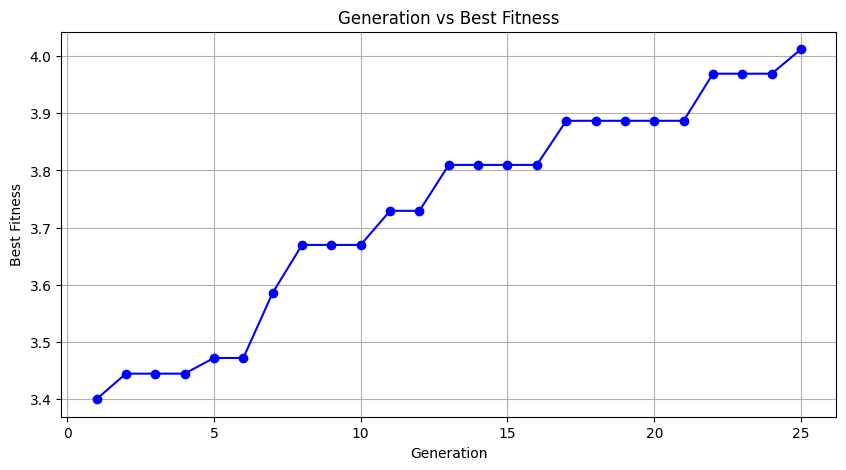

In [ ]:
generations = [i + 1 for i in range(len(best_fitnesses))]
plt.figure(figsize=(10, 5))
plt.plot(generations, best_fitnesses, marker='o', linestyle='-', color='b')
plt.title('Generation vs Best Fitness')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()

In [ ]:
results = logistic_regression_classifier(filtered_expression.iloc[:, 1:-1], expression.iloc[:, -1])
print('classification accuracy is ', results)

classification accuracy is  0.5833333333333334


# **Genetic Algorithms Combinations**

In [ ]:
crossover_probs = [0.1]
mutation_probs = [0.05]
population_sizes = [10, 25, 50]
max_features = [60, 120, 240]
fitness_functions = ["LR"]

In [ ]:
def run_experiments():
    results = []

    param_combinations = list(product(crossover_probs, mutation_probs, population_sizes, max_features, fitness_functions))

    for combo in param_combinations:
        crossover_prob, mutation_prob, population_size, max_selected_features, fitness_function = combo

        genes, best_fitnesses = genetic_algorithm(
            expression, population_size, num_generations=10, max_selected_features=max_selected_features,
            crossover_prob=crossover_prob, mutation_prob=mutation_prob, multiple_mutations=False, crossover_type='s', fitness_function=fitness_function
        )

        if fitness_function == 'mean':
          filtered_expression = expression[['Sample Identifier'] + genes + ['ICB Response']]
          accuracy = logistic_regression_classifier(filtered_expression.iloc[:, 1:-1], expression.iloc[:, -1])
        else:
          accuracy = best_fitnesses[-1]

        results.append({
            'Crossover Prob': crossover_prob,
            'Mutation Prob': mutation_prob,
            'Population Size': population_size,
            'Max Features': max_selected_features,
            'Fitness Function': fitness_function,
            'Accuracy': accuracy
        })
        print(f"Tested: {combo} with Accuracy: {accuracy}")

    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
results = run_experiments()

Generation 1: Best Fitness = 0.7083333333333334
Generation 2: Best Fitness = 0.7083333333333334
Generation 3: Best Fitness = 0.7083333333333334
Generation 4: Best Fitness = 0.7083333333333334
Generation 5: Best Fitness = 0.7083333333333334
Generation 6: Best Fitness = 0.7083333333333334
Generation 7: Best Fitness = 0.7083333333333334
Generation 8: Best Fitness = 0.7083333333333334
Generation 9: Best Fitness = 0.7083333333333334
Generation 10: Best Fitness = 0.75
Tested: (0.1, 0.05, 10, 60, 'LR') with Accuracy: 0.75
Generation 1: Best Fitness = 0.6666666666666666
Generation 2: Best Fitness = 0.6666666666666666
Generation 3: Best Fitness = 0.6666666666666666
Generation 4: Best Fitness = 0.6666666666666666
Generation 5: Best Fitness = 0.6666666666666666
Generation 6: Best Fitness = 0.7083333333333334
Generation 7: Best Fitness = 0.7083333333333334
Generation 8: Best Fitness = 0.7083333333333334
Generation 9: Best Fitness = 0.7083333333333334
Generation 10: Best Fitness = 0.708333333333333

In [ ]:
results.to_csv('comb_LR.tsv', sep='\t', index=False)

# **Evaluation**

In [19]:
MI_eval60 = evaluate_MI(expression.iloc[:, 1:-1], expression.iloc[:, -1], top_k=60)
MI_eval120 = evaluate_MI(expression.iloc[:, 1:-1], expression.iloc[:, -1], top_k=120)
MI_eval240 = evaluate_MI(expression.iloc[:, 1:-1], expression.iloc[:, -1], top_k=240)
print('Evaluation with MI (Features: 60, 120, 240): ', MI_eval60, MI_eval120, MI_eval240)

Evaluation with MI (Features: 60, 120, 240):  0.75 0.6666666666666666 0.5833333333333334


In [ ]:
rfe_eval60 = evaluate_rfe(expression.iloc[:, 1:-1], expression.iloc[:, -1], n_features_to_select=60, step=100)
rfe_eval120 = evaluate_rfe(expression.iloc[:, 1:-1], expression.iloc[:, -1], n_features_to_select=120, step=100)
rfe_eval240 = evaluate_rfe(expression.iloc[:, 1:-1], expression.iloc[:, -1], n_features_to_select=240, step=100)
print('Evaluation with RFE (Features: 60, 120, 240): ', rfe_eval60, rfe_eval120, rfe_eval240)

Evaluation with RFE (Features: 60, 120, 240):  0.8333333333333334 0.8333333333333334 0.875
